In [85]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator
import yfinance as yf

from lstm_functions import *
from lost_functions import *

# Reading and storing the Data

In [86]:
raw_data = {}
stock_list = ["XOM", "SHW", "UPS", "DUK", "UNH", "JPM", "AMZN", "AAPL", "MSFT", "AMT"]
start_date = '2000-01-01'
end_date = '2021-12-31'

# Initialize an empty DataFrame to store the data
all_data = pd.DataFrame()

# Loop through each stock symbol
for symbol in stock_list:
    # Download historical data from Yahoo Finance
    data = yf.download(symbol, start=start_date, end=end_date)
    
    # Calculate ATR (Average True Range)
    data['ATR'] = AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=14).average_true_range()
    
    # Calculate RSI (Relative Strength Index)
    data['RSI'] = RSIIndicator(close=data['Close'], window=14).rsi()
    
    # Select the features you're interested in
    features = data[['ATR', 'RSI', 'Volume', 'Adj Close']]
    
    # Drop rows with NaN values (if any)
    features = features.dropna()
    
    raw_data[symbol] = features

raw_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'XOM':                  ATR        RSI    Volume  Adj Close
 Date                                                
 2000-01-21  1.339286  63.336192  14343600  20.262377
 2000-01-24  1.361926  59.595089  12459400  20.083586
 2000-01-25  1.347235  58.662199  11921600  20.038885
 2000-01-26  1.317968  55.838243   9298000  19.904802
 2000-01-27  1.357756  45.381810  10548400  19.308855
 ...              ...        ...       ...        ...
 2021-12-23  1.515455  46.865506  13543300  57.272972
 2021-12-27  1.516494  51.427811  12593700  58.089546
 2021-12-28  1.473173  50.357357  12781000  57.901825
 2021-12-29  1.422947  47.483547  12733600  57.394993
 2021-12-30  1.380593  45.614607  11940300  57.057095
 
 [5522 rows x 4 columns],
 'SHW':                  ATR        RSI   Volume   Adj Close
 Date                                                
 2000-01-21  0.242559  21.491617  3363900    4.104717
 2000-01-24  0.240859  23.416933  1954800    4.119070
 2000-01-25  0.243000  25.387373  250500

generating weights for y_true

In [87]:
### question: not possible to normalise to (-1, 1) and sum to 0, need solve optimisation problem?

price_data = pd.concat([raw_data[i]['Adj Close'] for i in stock_list], axis=1)
price_data.columns = stock_list

## get the % returns
returns_data = price_data.pct_change().iloc[1:, :] 

## normalize weights to (0, 1)
sc = MinMaxScaler(feature_range = (0, 1))
weights_data = pd.DataFrame(sc.fit_transform(returns_data.T).T)

## Sum weights to 1
weights_data['total'] = weights_data.sum(axis=1)
for col in weights_data.columns:
    weights_data[col] = weights_data[col]/weights_data['total']
weights_data = weights_data.drop(columns=['total'])
weights_array = weights_data.values

weights_data.head()

,0,1,2,3,4,5,6,7,8,9
0,0.088739,0.112620,0.069814,0.131572,0.000000,0.107503,0.357655,0.017684,0.059136,0.055278
1,0.062832,0.088200,0.064307,0.058173,0.072720,0.171613,0.017288,0.323589,0.141277,0.000000
2,0.112131,0.104850,0.102960,0.133764,0.120779,0.225027,0.000000,0.089305,0.059877,0.051306
3,0.013853,0.123909,0.103010,0.132238,0.055689,0.188432,0.200645,0.097943,0.084280,0.000000
4,0.113592,0.110023,0.164420,0.137783,0.107933,0.062800,0.000000,0.004993,0.159667,0.138788


data preprocessing

In [88]:
## compress into 3x6 features

data = pd.concat([raw_data[i] for i in stock_list], axis=1)[1:]
data.head()

,ATR,RSI,Volume,Adj Close,ATR,RSI,Volume,Adj Close,ATR,RSI,...,Volume,Adj Close,ATR,RSI,Volume,Adj Close,ATR,RSI,Volume,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-24,1.361926,59.595089,12459400,20.083586,0.240859,23.416933,1954800,4.119070,1.984694,43.142939,...,440876800,0.805220,2.791932,30.172140,63597600,31.449379,1.987564,83.232596,2161100,33.124088
2000-01-25,1.347235,58.662199,11921600,20.038885,0.243000,25.387373,2505000,4.133422,1.976859,42.597298,...,497145600,0.850691,2.746527,34.237594,59823200,31.934706,1.988452,78.421600,788000,32.581875
2000-01-26,1.317968,55.838243,9298000,19.904802,0.240524,23.438959,1578000,4.090363,1.933869,39.379191,...,367158400,0.835060,2.706596,30.087367,49365000,30.866985,2.042848,68.702106,578600,31.349590
2000-01-27,1.357756,45.381810,10548400,19.308855,0.235248,27.437246,1505100,4.119070,1.893950,39.379191,...,340144000,0.833640,2.653893,29.389798,63654800,30.672844,2.062109,61.480813,975700,30.265150
2000-01-28,1.336666,38.740933,10361000,18.802286,0.230349,22.398455,1428300,4.004251,1.892596,38.535109,...,423348800,0.770169,2.571472,28.814246,58225400,30.517530,2.066601,58.759806,601300,29.821541


In [89]:
train_size = int(len(data) * 0.8)
sc = MinMaxScaler(feature_range = (0, 1))

weights_array_train = weights_array[:train_size]
weights_array_test = weights_array[train_size:]


train_data = data.iloc[:train_size]
train_array = train_data.values
train_scaled = sc.fit_transform(train_array)
print(train_data)
test_data = data.iloc[train_size:]
test_array = test_data.values
test_scaled = sc.fit_transform(test_array)

train, test = np.array(train_scaled), np.array(test_scaled)
print(train.shape)
print(test.shape)

## table containing prices of test set (for portfolio evaluation)
test_prices = price_data[train_size:].copy(deep=True)
test_prices = test_prices[31:]  ## batch_size=30 and first value of y is 0 due to pct_change diff
print(test_prices)

                 ATR        RSI    Volume  Adj Close       ATR        RSI  \
Date                                                                        
2000-01-24  1.361926  59.595089  12459400  20.083586  0.240859  23.416933   
2000-01-25  1.347235  58.662199  11921600  20.038885  0.243000  25.387373   
2000-01-26  1.317968  55.838243   9298000  19.904802  0.240524  23.438959   
2000-01-27  1.357756  45.381810  10548400  19.308855  0.235248  27.437246   
2000-01-28  1.336666  38.740933  10361000  18.802286  0.230349  22.398455   
...              ...        ...       ...        ...       ...        ...   
2017-08-04  0.860947  46.017767   8292200  59.057911  1.733722  30.605519   
2017-08-07  0.824451  45.584368   7893800  59.021107  1.711075  29.914208   
2017-08-08  0.793418  43.806909   9028400  58.873840  1.690284  28.019816   
2017-08-09  0.777460  46.609332   8087100  59.057911  1.743121  35.429158   
2017-08-10  0.814784  36.804908  12580300  58.708519  1.730040  31.439773   

data structure creation

In [90]:
batch_size = 30

x_train, y_train = [], []
x_test, y_test = [], []

for i in range(batch_size, train.shape[0]):
    x_train.append(train[i-batch_size: i, :])
    y_train.append(weights_array_train[i, :])

for i in range(batch_size, test.shape[0]):
    x_test.append(test[i-batch_size: i, :])
    y_test.append(weights_array_test[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4386, 30, 40) (4386, 10)
(1075, 30, 40) (1075, 10)


model initiation

In [91]:
num_units = [50, 40, 40, 40]

model = Sequential()

## can comment out FC layers too, but change first LSTM 2nd input to x_train.shape[2]
model.add(Dense(units=num_units[0], activation='swish', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(units=num_units[1], activation='swish'))
model.add(Dense(units=num_units[2], activation='swish'))
model.add(Dense(units=num_units[3], activation='swish'))

model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], num_units[3])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
# model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(Dropout(rate = 0.2))
model.add(LSTM(units=30, activation='relu', return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))

model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 30, 50)            2050      
                                                                 
 dense_24 (Dense)            (None, 30, 40)            2040      
                                                                 
 dense_25 (Dense)            (None, 30, 40)            1640      
                                                                 
 dense_26 (Dense)            (None, 30, 40)            1640      
                                                                 
 lstm_17 (LSTM)              (None, 30, 30)            8520      
                                                                 
 dropout_17 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_18 (LSTM)              (None, 30, 30)           

In [92]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x=x_train, y=y_train, batch_size=64, epochs=10)

Epoch 1/10
69/69 [==============================] - 3s 19ms/step - loss: 0.0695
Epoch 2/10
69/69 [==============================] - 1s 21ms/step - loss: 0.0107
Epoch 3/10
69/69 [==============================] - 2s 23ms/step - loss: 0.0079
Epoch 4/10
69/69 [==============================] - 2s 23ms/step - loss: 0.0071
Epoch 5/10
69/69 [==============================] - 2s 23ms/step - loss: 0.0067
Epoch 6/10
69/69 [==============================] - 2s 23ms/step - loss: 0.0064
Epoch 7/10
69/69 [==============================] - 2s 23ms/step - loss: 0.0062
Epoch 8/10
69/69 [==============================] - 2s 23ms/step - loss: 0.0060
Epoch 9/10
69/69 [==============================] - 2s 23ms/step - loss: 0.0059
Epoch 10/10
69/69 [==============================] - 2s 23ms/step - loss: 0.0059


In [96]:
# from keras.optimizers import Adam

# # Tuning parameters 
# param_space = {
#     'units_lstm': [20, 30, 40, 50],
#     'units_fc1': [10, 20, 30, 40],
#     'units_fc2': [10, 20, 30, 40],
#     'units_fc3': [10, 20, 30, 40],
#     'epochs': [10, 20, 30],
#     'batch_size': [32, 64, 128],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'dropout_rate': [0.1, 0.2, 0.3],
#     'loss': ['mean_squared_error'],
#     'layers': [1, 2, 3]
# }

# num_configs = 30
# best_loss = float('inf')
# best_hyperparameters = {}

# for _ in range(num_configs):
#     hyperparameters = {param: random.choice(values) for param, values in param_space.items()}

#     model = Sequential()
#     model.add(Dense(units=hyperparameters['units_lstm'], activation='swish'))
#     # Adding Dense layers
#     for i in range(hyperparameters['layers']):
#         units = hyperparameters[f'units_fc{i+1}']
#         model.add(Dense(units=units, activation='swish'))
    
#     # Adding LSTM layers
#     for i in range(hyperparameters['layers']):
#         units = hyperparameters['units_lstm']
#         model.add(LSTM(units=units, activation='relu', return_sequences=True if i < 2 else False))
#         model.add(Dropout(rate=hyperparameters['dropout_rate']))

#     # Adding output Dense layer
#     model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

#     model.compile(optimizer=Adam(learning_rate=hyperparameters['learning_rate']), loss='mean_squared_error')

#     # Train the model
#     history = model.fit(x=x_train, y=y_train, batch_size=hyperparameters['batch_size'],
#                         epochs=hyperparameters['epochs'], verbose=0)

#     val_loss = model.evaluate(x_test, y_test, verbose=0)

#     if val_loss < best_loss:
#         best_loss = val_loss
#         best_hyperparameters = hyperparameters

# # Print the best hyperparameters
# print("Best Hyperparameters:")
# print(best_hyperparameters)

# # Train the final model with the best hyperparameters
# final_model = Sequential()

# # Adding Dense layers
# model.add(Dense(units=hyperparameters['units_lstm'], activation='swish'))
# for i in range(best_hyperparameters['layers']):
#     units = best_hyperparameters[f'units_fc{i+1}']
#     final_model.add(Dense(units=units, activation='swish'))

# # Adding LSTM layers
# for i in range(best_hyperparameters['layers']):
#     units = best_hyperparameters['units_lstm']
#     final_model.add(LSTM(units=units, activation='relu', return_sequences=True if i < 2 else False))
#     final_model.add(Dropout(rate=best_hyperparameters['dropout_rate']))

# final_model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

# final_model.compile(optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']), loss=best_hyperparameters['loss'])
# final_model.fit(x=x_train, y=y_train, batch_size=best_hyperparameters['batch_size'], epochs=best_hyperparameters['epochs'])

InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/mean_squared_error/BroadcastGradientArgs' defined at (most recent call last):
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/1m/y4_k4vm931b40jc7hjp118rc0000gn/T/ipykernel_72875/1770050824.py", line 43, in <cell line: 21>
      history = model.fit(x=x_train, y=y_train, batch_size=hyperparameters['batch_size'],
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 598, in minimize
      grads_and_vars = self._compute_gradients(
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 656, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "/Users/guanzhou/opt/anaconda3/lib/python3.9/site-packages/keras/src/optimizers/legacy/optimizer_v2.py", line 532, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/mean_squared_error/BroadcastGradientArgs'
Incompatible shapes: [64,30,10] vs. [64,10]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_94604]

![Alt text](image-2.png)

model prediction

In [ ]:
y_pred = model.predict(x_test)
# y_pred_test = final_model.predict(x_test)

34/34 [==============================] - 0s 4ms/step


In [ ]:
# print(y_pred.shape)
# print(y_pred_test.shape)
print(y_test.shape)

(1075, 10)
(1075, 10)


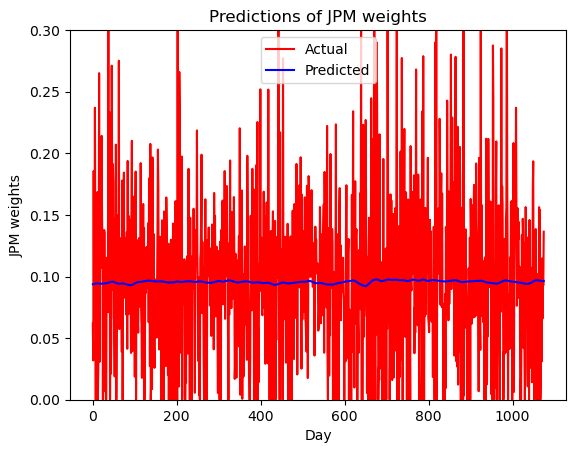

In [ ]:
stock = 'JPM'             # XOM, SHW, UPS, DUK, UNH, JPM, AMZN, AAPL, MSFT, AMT
col = stock_list.index(stock)

plt.plot(y_test[:, col], color='red', label='Actual')
plt.plot(y_pred[:, col], color='blue', label='Predicted')
plt.title(f'Predictions of {stock} weights')
plt.xlabel('Day')
plt.ylabel(f'{stock} weights')
plt.ylim([0, 0.3])
plt.legend()
plt.show()

In [ ]:
print(f'y_pred: {y_pred[0]}')
print(f'y_test: {y_test[0]}')

y_pred: [0.09816921 0.09981253 0.09478586 0.09791142 0.10136402 0.09369392
 0.10345003 0.1096047  0.09200248 0.10263678]
y_test: [0.21234936 0.16262789 0.1500861  0.19278007 0.0681321  0.06192805
 0.         0.05224591 0.00416807 0.09568244]


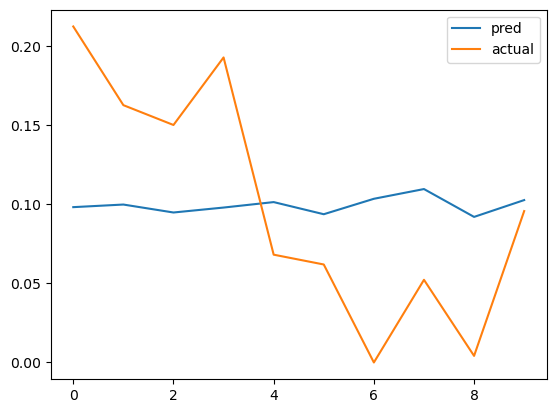

In [ ]:
plt.plot(y_pred[0], label='pred')
plt.plot(y_test[0], label='actual')
plt.legend()
plt.show()

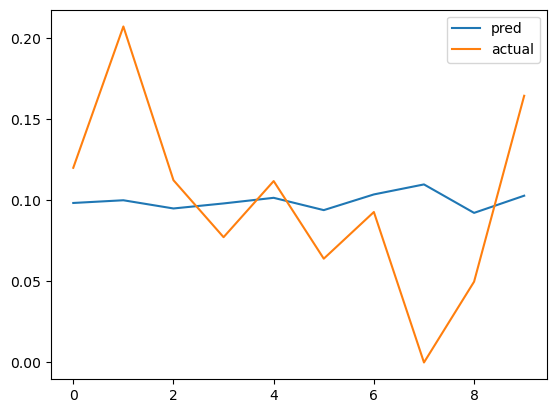

In [ ]:
plt.plot(y_pred[3], label='pred')
plt.plot(y_test[3], label='actual')
plt.legend()
plt.show()

generate table of stock weights

In [ ]:
weights_pred = pd.DataFrame(y_pred)
weights_pred.columns = stock_list
weights_pred.index = test_prices.index.copy()
weights_pred.head()

# weights_pred_test = pd.DataFrame(y_pred_test)
# weights_pred_test.columns = stock_list
# weights_pred_test.index = test_prices.index.copy()

,XOM,SHW,UPS,DUK,UNH,JPM,AMZN,AAPL,MSFT,AMT
Date,,,,,,,,,,
2017-09-25,0.098169,0.099813,0.094786,0.097911,0.101364,0.093694,0.103450,0.109605,0.092002,0.102637
2017-09-26,0.098233,0.099883,0.094845,0.097962,0.101421,0.093774,0.103514,0.109667,0.092082,0.102710
2017-09-27,0.098298,0.099955,0.094908,0.098018,0.101481,0.093860,0.103576,0.109732,0.092164,0.102780
2017-09-28,0.098376,0.100048,0.094986,0.098088,0.101556,0.093967,0.103649,0.109815,0.092268,0.102864
2017-09-29,0.098456,0.100146,0.095062,0.098157,0.101632,0.094075,0.103722,0.109899,0.092375,0.102950


portfolio evaluation

In [101]:
def backtest(test_df, weights):
    '''
    df of stocks with index being date, cols being stocks, each entry being the price 
    weights represent the normalized portfolio weights
    '''
    returns = test_df.pct_change().dropna()

    portfolio_returns = (returns * weights).sum(axis=1)

    cumulative_returns = (1 + portfolio_returns).cumprod()

    annualized_return = (cumulative_returns[-1])**(252/len(cumulative_returns.index)) - 1  # Assuming 252 trading days
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)

    # Calculate Sharpe Ratio
    risk_free_rate = 0.03 # can change 
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate Maximum Drawdown
    cumulative_returns_index = (1 + portfolio_returns).cumprod()
    cumulative_max = cumulative_returns_index.cummax()
    drawdown = (cumulative_returns_index - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns)
    plt.title('Portfolio Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()

# backtest(test_prices, weights_pred)
# backtest(test_prices, weights_pred_test)

Annualized Return: -75.21%
Annualized Volatility: 48.19%
Sharpe Ratio: -1.62
Maximum Drawdown: -82.98%


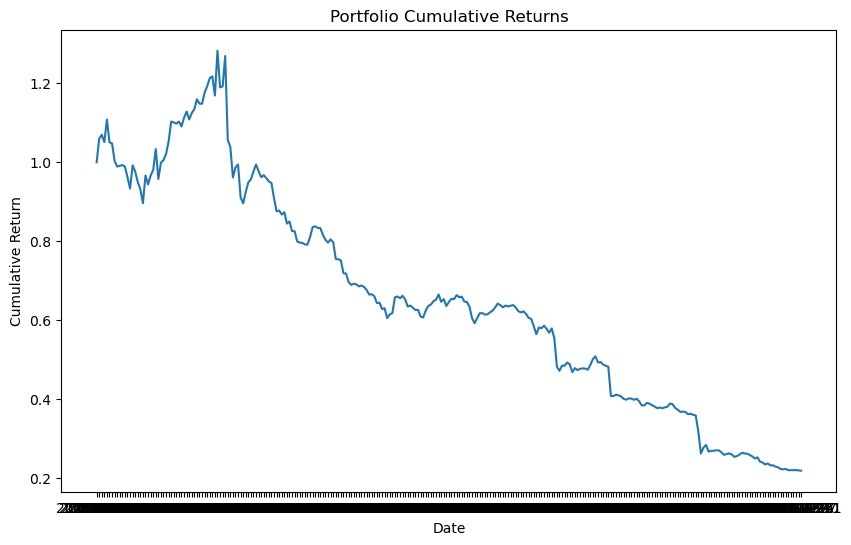

In [104]:
alvin_test = pd.read_csv('truth.csv').set_index('Date')
weights = pd.read_csv('portfolio_weights.csv').set_index('Date')
backtest(alvin_test, weights)

In [ ]:
def custom_loss_1(y_true, y_pred):
    # y_true is the s&p500 returns
    # y_pred is the array of weights for each stock
    # we want to maximise y_pred - s&p500 returns (at least 20% higher)
    # aka minimise s&p500 returns - y_pred

    # <normalize>
    # predicted weights for day i * returns on day i = total returns
    # compare w s&p500 returns

    return y_true*1.2 - y_pred

In [ ]:
# Loop through each stock data
for ticker, data in all_data.items():
    
    # Drop non-numeric columns
    data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
    lstm_model = LstmBuilder(time_step=time_steps, loss=huber_loss)
    model = lstm_model.create_model(features=features)
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    X, y = lstm_model.create_sequences(normalized_data)
    X_train, X_test, y_train, y_test = lstm_model.split_data(X,y)
    
    print("Working on: " + ticker)  
    model.fit(X_train, y_train, epochs=3, batch_size=4, validation_split=0.2, verbose=0)
    '''
    Batch Size: Refers to the number of training examples utilized in one iteration. When you set batch_size=32, it means the model takes 32 sequences at a time and updates weights once after computing the loss of the entire batch.
    Input Shape (60, 6): Refers to the shape of a single input sequence.
    60 indicates the number of time steps in each sequence. In your case, each sequence contains data from 60 days.
    6 refers to the number of features ('Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume').
    So, when you train your LSTM, it takes in 32 sequences (if we consider batch_size=32) at a time, and each of those sequences contains 60 time steps with 6 features for each time step.

    In simpler terms:

    Input Shape: Shape of a single sequence that you feed into the model.
    Batch Size: Number of sequences you feed into the model at one go.
    These two are different parameters and have different roles in the training process. The batch size is related to how you update the weights during training, whereas the input shape is related to the structure and size of your input data.
    '''
    
    # Predict the next day value
    last_days = normalized_data[-time_steps:].reshape(1, time_steps, features)
    prediction_next_day = model.predict(last_days)
    prediction_next_day_actual = scaler.inverse_transform(prediction_next_day)
    final_predictions[ticker] = prediction_next_day_actual.flatten()
    print(f"Predicted value for {ticker}: {prediction_next_day_actual.flatten()}")

    
    # Extracting importance
    dense_weights = model.layers[-1].get_weights()[0]

    # Think about to use sum or mean and to use abs() or not
    feature_weights = dense_weights.sum(axis=0)
    weighted_importance = prediction_next_day.flatten() * feature_weights
    final_importance_value = np.sum(weighted_importance)  # Final importance as a single value
    print(f"Importance value for {ticker}: {final_importance_value}")
    
    # Store the importance value in the dictionary
    final_importance_values[ticker] = final_importance_value

print(final_importance_values)

NameError: name 'final_importance_values' is not defined

In [ ]:
final_importance_values

: 

In [ ]:
importance_values = np.array(list(final_importance_values.values()))

: 

# Run this if we want a arbitrage strategy
Each weight will be -1 to 1, the sum is 0

In [ ]:
## testing his normalization code

importance_values = [-24.02027, 5.5614214, 5.2308617, -5.3437276, 0.14171359, 100]

arbitrage_scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
arbitrage_normalized_importance = arbitrage_scaled_importance - np.mean(arbitrage_scaled_importance)

arbitrage_normalized_importance


: 

In [ ]:
# 1. Scale the values to [-1, 1]
arbitrage_scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
arbitrage_normalized_importance = arbitrage_scaled_importance - np.mean(arbitrage_scaled_importance)

# Convert back to dictionary
arbitrage_ticker_to_importance = dict(zip(final_importance_values.keys(), arbitrage_normalized_importance))

print(arbitrage_ticker_to_importance)

: 

# Run this instead if we want a normal strategy
Each weight will be 0 to 1, the sum is 1

In [ ]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))  # subtract max to avoid potential overflow
    return e_x / e_x.sum(axis=0)

# Convert the importance values to probabilities using softmax
probabilities = softmax(importance_values)

# Convert back to dictionary
normalized_ticker_to_importance = dict(zip(final_importance_values.keys(), probabilities))

print(normalized_ticker_to_importance)

: 

In [ ]:
def plot_importance(normalized_ticker_to_importance = normalized_ticker_to_importance, title='Normalized Importance Values'):
# Split the tickers and importance values based on positive and negative values
    long_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v > 0}
    short_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v <= 0}

    # Sort the positions for better visualization
    sorted_long = dict(sorted(long_positions.items(), key=lambda item: item[1], reverse=True))
    sorted_short = dict(sorted(short_positions.items(), key=lambda item: item[1]))

    # Create bar charts
    fig, ax = plt.subplots(figsize=(12, 7))

    # Positive cluster
    bars_long = ax.bar(sorted_long.keys(), sorted_long.values(), color='g', label='Long')

    # Negative cluster
    bars_short = ax.bar(sorted_short.keys(), sorted_short.values(), color='r', label='Short')

    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Annotate the bars
    for bar in bars_long:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=9)

    for bar in bars_short:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval - 0.02, round(yval, 3), ha='center', va='top', fontsize=9)

    ax.set_title(title)
    ax.set_ylabel('Importance Value')
    ax.set_xlabel('Ticker')
    ax.legend()

    plt.tight_layout()
    plt.show()


: 

In [ ]:
# Plot the arbitrage importance values
plot_importance(arbitrage_ticker_to_importance, title='Arbitrage Importance Values')

: 

In [ ]:
# Plot the importance values
plot_importance(normalized_ticker_to_importance, title='Normalized Importance Values')

: 

In [ ]:
spy_data = yf.download('SPY')
spy_monthly = spy_data.resample('M').last()
spy_monthly

: 

In [ ]:
all_data

: 

In [ ]:
# Construct the Portfolio and Backtest
def build_portfolio(normalized_ticker_to_importance=normalized_ticker_to_importance, strategy='Normal'):
    portfolio_returns = pd.DataFrame()
    for ticker, importance in normalized_ticker_to_importance.items():
        data = all_data[ticker].set_index('Date')
        data['Returns'] = data['Adj Close'].pct_change().fillna(0)
        portfolio_returns[ticker] = data['Returns'] * importance
    portfolio_returns['Portfolio'] = portfolio_returns.sum(axis=1)
    spy_monthly['SPY Returns'] = spy_monthly['Adj Close'].pct_change().fillna(0)
    # Cumulative Returns
    portfolio_returns['Cumulative Portfolio'] = (portfolio_returns['Portfolio'] + 1).cumprod() - 1
    spy_monthly['Cumulative SPY'] = (spy_monthly['SPY Returns'] + 1).cumprod() - 1
    combined = pd.concat([portfolio_returns['Cumulative Portfolio'], spy_monthly['Cumulative SPY']], axis=1).dropna()
    print(combined)
    # Plot
    plt.figure(figsize=(14,7))
    combined['Cumulative Portfolio'].plot(label="Portfolio")
    combined['Cumulative SPY'].plot(label="SPY")
    plt.legend()
    plt.title(strategy + " Portfolio vs. SPY Cumulative Returns")
    plt.show()


: 

In [ ]:
# Build the portfolio for arbitrage strategy
build_portfolio(arbitrage_ticker_to_importance, strategy='Arbitrage')

: 

In [ ]:
# Build the portfolio for the Normal strategy
build_portfolio(normalized_ticker_to_importance, strategy='Normal')

: 